### Introduction

Looking at some of the error shapes, especially in $\phi$ - radial streaks moving away from resonance - I wondered if other smooth function interpolation methods would show the same sort of mistakes. I will focus on real space, with the center_very_broad and the peak_broad domains, where the system succeeded but struggled. I will also focus on $\phi$ over amplitude, because while its unsurprising that large, varying errors make it difficult for the network, its more interesting to see how badly a single discontinuity can do that.

First, we'll load the parameters of center_very_broad and produce some data.

In [11]:
from utils import *
from datafile import *
from poly import *

fname = 'center_very_broad'

beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB = get_params(fname)
print([beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB])

z, o = datagen(muW, muB, stdW, stdB, datasize)

w = z[:, 0].reshape(datasize)
b = z[:, 1].reshape(datasize)
p = o[:, 0].reshape(datasize)

beta,latent,datasize,learning_rate,epochs,muW,muB,stdW,stdB

[0.01, 5, 2048, 0.0001, 50000, 1.0, 0.5, 0.2, 0.2]


Next, lets fit a polynomial model, starting with degree $13$ (closest match in error), and see how well it performs on this data.

In [26]:
deg = 13

params = fitpoly(w, b, p, deg)

p_pred = polyeval(w, b, params, deg)

errors = p - p_pred

print(errors)

[ 0.00178684 -0.00135293 -0.02242953 ...  0.00824555  0.00242946
 -0.13474127]


/home/atb86/allAstuff/pytorchOscilator/poly.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params, _, _, _ = lstsq(x_, y)


In [27]:
prange = max(p) - min(p)

# I average the squared errors because the network is trained to minimize error**2, 
# but I compute the square root so we can compare this to the ranges.
typicalpe = np.sqrt(np.mean(errors**2))

print("Typical Phase Error")
print(typicalpe)

print("Typical phase error / phase range")
print(typicalpe/prange)

Typical Phase Error
0.018388758220797934
Typical phase error / phase range
0.005959566842622931


So far, so good. Now, let's graph this function to understand it.

## Plots of the Function

### Behavior Near Training Distribution

Let's plot the phase within $2\sigma$ of the mean of the training distribution.

In [28]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


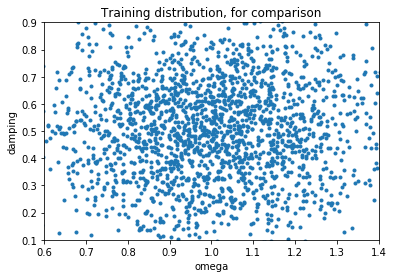

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# Plot some training data

fig = plt.figure()
plt.scatter(z[:, 0], z[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [30]:
# Compute the ground truth

Phi = phi(W, B)

In [31]:
# Compute the model output

modelPhi = polyeval(W, B, params, deg)

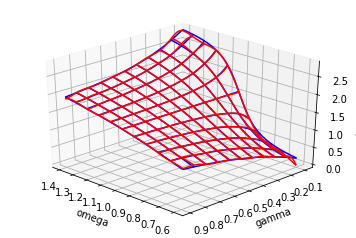

In [32]:
# Plot Phi, true and modeled

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")


fig

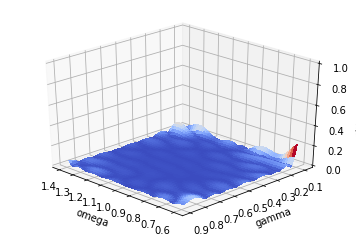

In [33]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")
ax.set_zlim([0, 1])

fig

### Behavior in Extrapolation

And now, let's see how well the model performs away from the training distribution

In [34]:
# Make the data

wmin = 0.2
wmax = 5.0
wstep = (wmax - wmin)/100

bmin = 0.01
bmax = 1.0
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)
print(W.shape)

(101, 100)


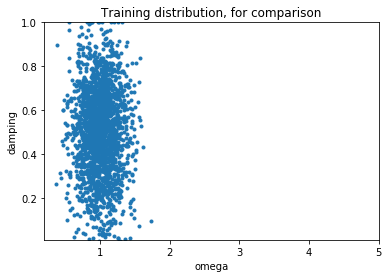

In [36]:
# Plot some training data

fig = plt.figure()
plt.scatter(z[:, 0], z[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [37]:
# Compute the ground truth

Phi = phi(W, B)

In [38]:
# Compute the model output

modelPhi = polyeval(W, B, params, deg)

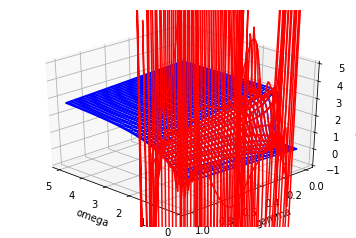

In [40]:
# Plot Phi, true and modeled

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")
ax.set_zlim(-1, 5)

fig

### Behavior during Slight Extrapolation.

It seems that huge extrapolation is much harder for high-degree polynmoials than for the neural net, but let's take a look at slight extrapolation instead.

In [53]:
# Make the data

wmin = 0.5
wmax = 1.5
wstep = (wmax - wmin)/100

bmin = 0.01
bmax = 1.0
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)
print(W.shape)

(101, 100)


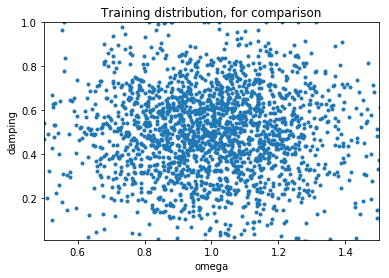

In [54]:
# Plot some training data

fig = plt.figure()
plt.scatter(z[:, 0], z[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [55]:
# Compute the ground truth

Phi = phi(W, B)

In [56]:
# Compute the model output

modelPhi = polyeval(W, B, params, deg)

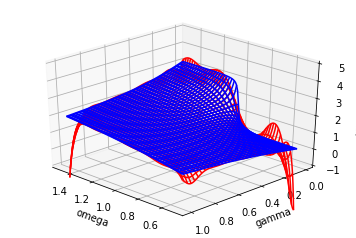

In [57]:
# Plot Phi, true and modeled

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")
ax.set_zlim(-1, 5)

fig

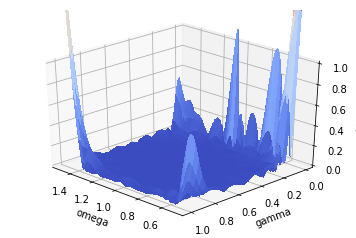

In [59]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")
ax.set_zlim([0, 1])

fig

### Conclusion

So it appears that a very high degree polynomial is significantly worse at extrapolation after all. The choice of ELU units in the neural network is smart - these are nonlinear functions whose growth is reasonable on all parts of the domain.

Let's take a look at the performance of lower degree polynomials, however. Will they sacrifice on-domain performance for extrapolation?